### Xiaotong He
### DSC672

In [1]:
import pandas as pd
import glob
import json
from pandas import json_normalize
from ast import literal_eval
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)

## Data Preprocessing

In [3]:
filename = 'data/train.csv'
def read_file(file):
    dtypes = {'date':'str','fullVisitorId': 'str'}
    parse_dates = ['date']
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime',
    ]
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(file, dtype = dtypes, parse_dates = parse_dates,
                    converters={column: json.loads for column in JSON_COLUMNS},
                    usecols=USE_COLUMNS)
    
# transform time feature
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['hour']=pd.to_datetime(df['visitStartTime'],unit='s').dt.hour

# flatten json cols
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

# drop cols   
    drop_cols = [
    'visitStartTime',
#     'date',
#     'fullVisitorId',
#     'visitId',
        
    'socialEngagementType',
    
    'device_browserSize',
    'device_operatingSystemVersion',
    'device_mobileDeviceBranding',
    'device_mobileDeviceModel',
    'device_mobileInputSelector',
    'device_mobileDeviceInfo',
    'device_mobileDeviceMarketingName',
    'device_flashVersion',
    'device_language',
    'device_screenColors',
    'device_screenResolution',
    'device_browserVersion',
    
    'geoNetwork_cityId',
    'geoNetwork_latitude',
    'geoNetwork_longitude',
    'geoNetwork_networkLocation',
    
    'totals_visits',
    
    'trafficSource_adwordsClickInfo.criteriaParameters',
    'trafficSource_referralPath',       
    'trafficSource_adwordsClickInfo.page',         
    'trafficSource_adwordsClickInfo.slot',             
    'trafficSource_adwordsClickInfo.gclId',            
    'trafficSource_adwordsClickInfo.adNetworkType',
    'trafficSource_adContent',                     
    'trafficSource_campaignCode', 
        
    'geoNetwork_continent',
    'geoNetwork_region',
    'geoNetwork_metro',
    'geoNetwork_city',
    'geoNetwork_networkDomain',
    'trafficSource_keyword',   
    ]
    
    df = df.drop(drop_cols,axis=1)
    return df

In [ ]:
# --fill missing values--
def fill_missing(df):
    values = {
              'totals_transactionRevenue' : 0,
              'trafficSource_adwordsClickInfo.isVideoAd' : True,
              'trafficSource_isTrueDirect' : False,
              'trafficSource_keyword' : '(not provided)',
              'totals_pageviews' : 1, 
              'totals_bounces':0,
              'totals_newVisits':0,
              'totals_timeOnSite':0,
              'totals_transactionRevenue':0
             }
    df = df.fillna(value=values)
    
    # --convert type--
    df = df.astype({
                'totals_hits': 'int64',
                'totals_pageviews': 'int64',
                'totals_newVisits': 'int64',
                'totals_transactionRevenue': 'int64',
                'totals_bounces': 'int64',})
    return df

In [ ]:
df = read_file(filename)
clean_df = fill_missing(df)

In [ ]:
# clean_df.to_csv('data/clean_data.csv')

In [4]:
clean_df = pd.read_csv('data/clean_data.csv',index_col=0)

/Users/xiaotonghe/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
clean_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,year,month,day,dayofweek,hour,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_subContinent,geoNetwork_country,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.isVideoAd
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,2016,9,2,4,15,Chrome,Windows,False,desktop,Western Asia,Turkey,1,1,1,1,0,(not set),google,organic,False,True
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,2016,9,2,4,5,Firefox,Macintosh,False,desktop,Australasia,Australia,1,1,1,1,0,(not set),google,organic,False,True
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,2016,9,2,4,1,Chrome,Windows,False,desktop,Southern Europe,Spain,1,1,1,1,0,(not set),google,organic,False,True
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,2016,9,2,4,5,UC Browser,Linux,False,desktop,Southeast Asia,Indonesia,1,1,1,1,0,(not set),google,organic,False,True
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,2016,9,2,4,13,Chrome,Android,True,mobile,Northern Europe,United Kingdom,1,1,1,0,0,(not set),google,organic,True,True


### feature engineering <br>
categorical var binning <br>

In [6]:
# device_browser
keep_lst = ['Chrome','Safari','Firefox','Internet Explorer','Edge',                                            
'Android Webview','Safari (in-app)','Opera Mini','Opera','UC Browser','YaBrowser']
clean_df['device_browser'] = clean_df['device_browser'].apply(lambda x: 'Others' if x not in keep_lst else x)

In [7]:
# device_operatingSystem
keep_lst = ['Windows','Macintosh','Android','iOS','Linux','Chrome','OS','(not set)']
clean_df['device_operatingSystem'] = clean_df['device_operatingSystem'].apply(lambda x: 'Others' if x not in keep_lst else x)

In [8]:
# trafficSource_source
keep_lst = ['google','youtube.com','(direct)','mall.googleplex.com','Partners']
clean_df['trafficSource_source'] = clean_df['trafficSource_source'].apply(lambda x: 'Others' if x not in keep_lst else x)

'totals_transactionRevenue' / 100000<br>
because Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6 (e.g., 2.40 would be given as 2400000).

In [9]:
clean_df['totals_transactionRevenue'] = clean_df['totals_transactionRevenue'].apply(lambda x: x/1000000) 

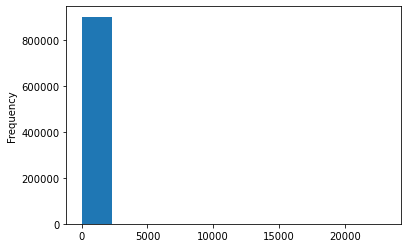

In [10]:
clean_df['totals_transactionRevenue'].plot(kind='hist')

normalization for 'totals_transactionRevenue'

In [11]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(clean_df['totals_transactionRevenue'].values.reshape(-1,1))
clean_df['totals_transactionRevenue_nor'] = scaler.transform(clean_df['totals_transactionRevenue'].values.reshape(-1,1))

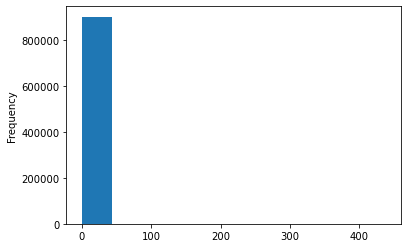

In [12]:
clean_df['totals_transactionRevenue_nor'].plot(kind='hist')

## Model Building

In [13]:
tr_df = clean_df.copy()

In [14]:
drop_cols = ['fullVisitorId','visitId']
tr_df = tr_df.drop(drop_cols,axis=1)

variables encoding

In [15]:
cat_cols = [
    'channelGrouping', 'device_browser','device_operatingSystem','device_isMobile',
    'device_deviceCategory','geoNetwork_subContinent','geoNetwork_country','trafficSource_campaign',
    'trafficSource_source','trafficSource_medium','trafficSource_isTrueDirect',
    'trafficSource_adwordsClickInfo.isVideoAd' 
]

num_cols = [
    'visitNumber','year','month','day','dayofweek','hour','totals_hits','totals_pageviews',
    'totals_bounces','totals_newVisits'
]

target_var = ['totals_transactionRevenue_nor']


In [16]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(tr_df[col].values.astype('str')))
    tr_df[col] = lbl.transform(list(tr_df[col].values.astype('str')))

channelGrouping
device_browser
device_operatingSystem
device_isMobile
device_deviceCategory
geoNetwork_subContinent
geoNetwork_country
trafficSource_campaign
trafficSource_source
trafficSource_medium
trafficSource_isTrueDirect
trafficSource_adwordsClickInfo.isVideoAd


In [17]:
tr_df.groupby(['year','month']).count()

channelGrouping    date  visitNumber     day  dayofweek    hour  \
year month                                                                    
2016 8                74759   74759        74759   74759      74759   74759   
     9                71032   71032        71032   71032      71032   71032   
     10               97506   97506        97506   97506      97506   97506   
     11              113972  113972       113972  113972     113972  113972   
     12               79124   79124        79124   79124      79124   79124   
2017 1                64694   64694        64694   64694      64694   64694   
     2                62192   62192        62192   62192      62192   62192   
     3                69931   69931        69931   69931      69931   69931   
     4                67126   67126        67126   67126      67126   67126   
     5                65371   65371        65371   65371      65371   65371   
     6                63578   63578        63578   63578      63578   63578   
     7                71812   71812        71812   71812      71812   71812   
     8                 2556    2556         2556    2556       2556    2556   

            device_browser  device_operatingSystem  device_isMobile  \
year month                                                            
2016 8               74759                   74759            74759   
     9               71032                   71032            71032   
     10              97506                   97506            97506   
     11             113972                  113972           113972   
     12              79124                   79124            79124   
2017 1               64694                   64694            64694   
     2               62192                   62192            62192   
     3               69931                   69931            69931   
     4               67126                   67126            67126   
     5               65371                   65371            65371   
     6               63578                   63578            63578   
     7               71812                   71812            71812   
     8                2556                    2556             2556   

            device_deviceCategory  geoNetwork_subContinent  \
year month                                                   
2016 8                      74759                    74759   
     9                      71032                    71032   
     10                     97506                    97506   
     11                    113972                   113972   
     12                     79124                    79124   
2017 1                      64694                    64694   
     2                      62192                    62192   
     3                      69931                    69931   
     4                      67126                    67126   
     5                      65371                    65371   
     6                      63578                    63578   
     7                      71812                    71812   
     8                       2556                     2556   

            geoNetwork_country  totals_hits  totals_pageviews  totals_bounces  \
year month                                                                      
2016 8                   74759        74759             74759           74759   
     9                   71032        71032             71032           71032   
     10                  97506        97506             97506           97506   
     11                 113972       113972            113972          113972   
     12                  79124        79124             79124           79124   
2017 1                   64694        64694             64694           64694   
     2                   62192        62192             62192           62192   
     3                   69931        69931             69931           69931   
     4             

feature selection

In [18]:
def features_filter(df,cols):
    new_df = df.filter(cols, axis=1)
    return new_df

Estimate mutual information for a continuous target variable.

In [19]:
features = cat_cols + num_cols

In [20]:
X_df = features_filter(tr_df,features)
y_df = features_filter(tr_df,target_var)

In [28]:
from sklearn import feature_selection
F_value,p_value=feature_selection.f_regression(X_df,y_df.values.ravel())

In [41]:
len(features)

22

In [40]:
d = {'feature':features,'F':F_value}
pd.DataFrame(data=d).sort_values(['F'],ascending=False)

,feature,F
19,totals_pageviews,22418.536796
18,totals_hits,22048.815577
12,visitNumber,2390.593888
21,totals_newVisits,1533.788651
20,totals_bounces,938.238545
10,trafficSource_isTrueDirect,859.103545
6,geoNetwork_country,453.442121
3,device_isMobile,247.715195
4,device_deviceCategory,219.388193
1,device_browser,208.520281


train and test set

In [42]:
# spliit train and test dataset based on time
import datetime
tr_df['date'] = pd.to_datetime(tr_df['date'])
train_df = tr_df[tr_df['date']<='2017-05-31']
valid_df = tr_df[tr_df['date']>'2017-05-31']

In [43]:
train_df = train_df.drop(['date'],axis=1)
valid_df = valid_df.drop(['date'],axis=1)

In [44]:
train_df.head()

,channelGrouping,visitNumber,year,month,day,dayofweek,hour,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_subContinent,geoNetwork_country,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo.isVideoAd,totals_transactionRevenue_nor
0,4,1,2016,9,2,4,15,1,5,0,0,21,204,1,1,1,1,0.0,0,3,5,0,1,-0.032291
1,4,1,2016,9,2,4,5,3,3,0,0,1,12,1,1,1,1,0.0,0,3,5,0,1,-0.032291
2,4,1,2016,9,2,4,1,1,5,0,0,19,181,1,1,1,1,0.0,0,3,5,0,1,-0.032291
3,4,1,2016,9,2,4,5,10,2,0,0,16,94,1,1,1,1,0.0,0,3,5,0,1,-0.032291
4,4,2,2016,9,2,4,13,1,1,1,1,13,211,1,1,1,0,0.0,0,3,5,1,1,-0.032291


separate dependent and independent variables

In [54]:
df1 = train_df.copy()
df2 = valid_df.copy()
drop_cols = ['totals_transactionRevenue_nor','totals_transactionRevenue']
X_train = df1.drop(drop_cols,axis=1)
X_valid = df2.drop(drop_cols,axis=1)
y_train = train_df['totals_transactionRevenue_nor']
y_valid = valid_df['totals_transactionRevenue_nor']

select features by F_value, dropped featur

In [55]:
drop_cols = ['channelGrouping','device_operatingSystem','trafficSource_campaign','year',
            'trafficSource_adwordsClickInfo.isVideoAd','day']
X_train = X_train.drop(drop_cols,axis=1)
X_valid = X_valid.drop(drop_cols,axis=1)

## Model Building

baseline model<br>
### 1) gradient boosting

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [58]:
preds = reg.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.926981


### 2) xgboost

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
params = {
    'objective':'reg:squarederror',
    'colsample_bytree':0.3,
    'learning_rate':0.01,
    'max_depth':5,
    'alpha':10,
    'n_estimators':10,
}
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, preds))
print("RMSE: %f" % (rmse))


RMSE: 0.955003


feature importance

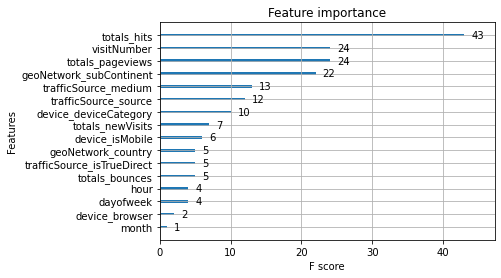

In [62]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### 3) light gbm

In [59]:
# custom function to run light gbm model
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : 1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=100)
    
#     pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

# Training the model #
model, pred_val = run_lgb(X_train, y_train, X_valid, y_valid)

/Users/xiaotonghe/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 0.933254
[200]	valid_0's rmse: 0.927715
[300]	valid_0's rmse: 0.924967
[400]	valid_0's rmse: 0.924287
[500]	valid_0's rmse: 0.924325
[600]	valid_0's rmse: 0.924879
[700]	valid_0's rmse: 0.925265
[800]	valid_0's rmse: 0.925804
[900]	valid_0's rmse: 0.926306
[1000]	valid_0's rmse: 0.926582
Did not meet early stopping. Best iteration is:
[443]	valid_0's rmse: 0.924162


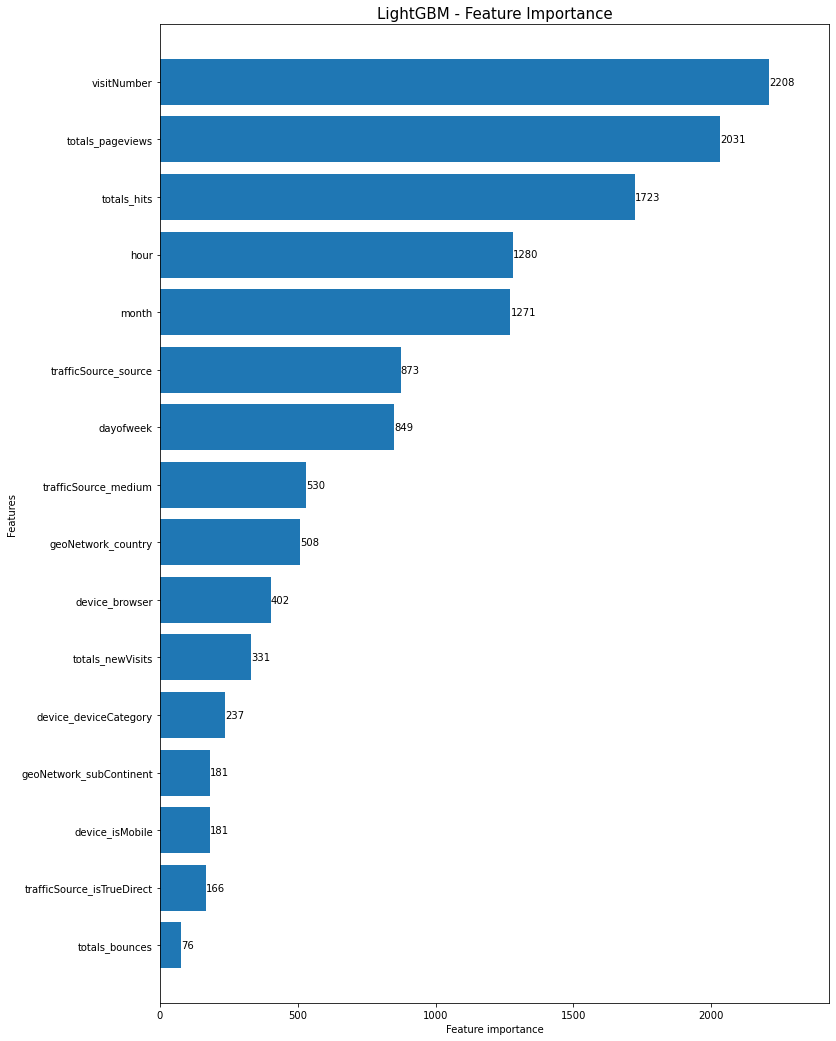

In [60]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Hypertuning

## Model Evaluation